In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from scipy.stats import shapiro
pd.set_option('display.max_rows', 500)
import warnings; warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
dirname = r'../input/titanic'

In [3]:
df = pd.read_csv(os.path.join(dirname, 'train.csv'))
df_test = pd.read_csv(os.path.join(dirname, 'test.csv'))
df_submit = pd.read_csv(os.path.join(dirname, 'gender_submission.csv'))

# ***TITANIC DIGI-PSYCHIC: WHO LIVES AND WHO DIES?! ***
## LETS GO:

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 well first lets ask the internet...
### INTERNET FACTS ABOUT WHO DIED AND WHO LIVED:

1. 68% of everyone on board died.
2. Of the victims, 832 were passengers, 685 were crew members.
3. 39% of first class, 58% of second class, 76% of third class died. That shit tracks.
4. 1 child from first class died. 52 from the poorest families died. Also tracks.
5. **724** crew members were from Southampton, and only **175** were returned home.
6. 80% of the male passengers and 25% of the female passengers died.

*thank u titanicfacts.net* <3

# 1. POKIN' AROUND

In [5]:
# just check out what exists in this column
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
#seeing how many ghosts im dealing with here

df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
#comparing male deaths to female deaths

crosstab = pd.crosstab(df['Sex'], df['Survived'], dropna = False)
crosstab

Survived,0,1
Sex,,
female,81,233
male,468,109


### down with the patirarchy, amirite

In [8]:
#class death divide

crasstab2 = pd.crosstab(df['Pclass'], df['Survived'], dropna = False) 
crasstab2 # NICE TYPO, ill take it!

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


### so far this is all matching what the internet told me. The rich and females had a much higher chance of survival than anyone else.

Curious about the variance in that fare column...

<AxesSubplot:xlabel='Fare', ylabel='Count'>

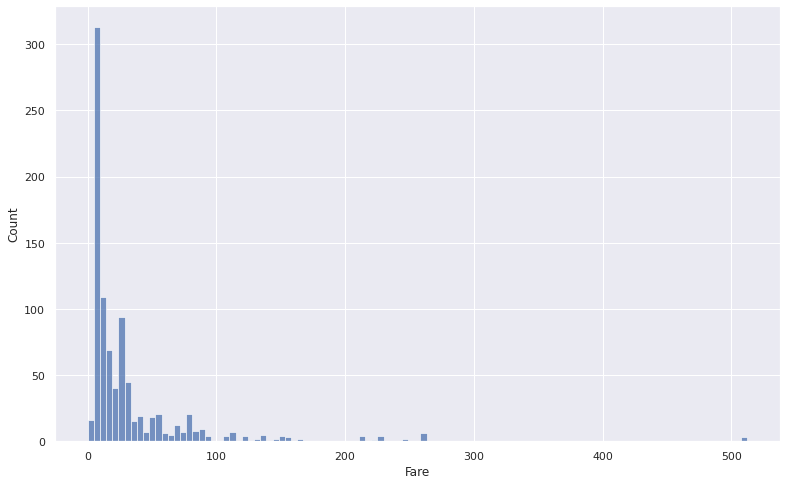

In [9]:
# I like a big chart

sns.set(rc = {'figure.figsize':(13,8)})

#fare price histo

sns.histplot(data=df, x="Fare")

# WTF why did someone pay 500 dollars for this trip

In [10]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

### Upon further research, 500 dollars is not even close to the most expensive ticket that was bought. According to Money.com, Charlotte Cardeza bought a ticket for 2500 bucks in "back-then" money. Insanity.

Ok, enough poking around, lets start changing some stuff.

# 2. WRANGLE/CLEAN

### Goals and Checklist: 
1. Change male and female to 0 and 1 (*check*!)
2. Change Embarked "S,C,Q" to "1,2,3", in order of most deaths per port (*check*!)
3. Delete 'ticket' and 'name' columns (*check*!)
4. Look a little more into 'Cabin' (*check*!)
5. Address any nulls (*check*!)




# 2.1

In [11]:
# first change sex column

df.loc[df['Sex'] == 'male', 'Sex'] = 0
df.loc[df['Sex'] == 'female', 'Sex'] = 1

In [12]:
df['Sex'].value_counts() # nice

0    577
1    314
Name: Sex, dtype: int64

# 2.2

In [13]:
# change Embarked column: 
df.loc[df['Embarked'] == 'S', 'Embarked'] = 1
df.loc[df['Embarked'] == 'C', 'Embarked'] = 2
df.loc[df['Embarked'] == 'Q', 'Embarked'] = 3

In [14]:
df['Embarked'].value_counts() # Niiiiice

1    644
2    168
3     77
Name: Embarked, dtype: int64

# 2.3

In [15]:
# get rid of name column
del df['Name']

In [16]:
# whoops also waanted to get rid of the ticket column
del df['Ticket']

In [17]:
df.head() # niiiice

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,NaN,1
1,2,1,1,1,38.0,1,0,71.2833,C85,2
2,3,1,3,1,26.0,0,0,7.9250,NaN,1
3,4,1,1,1,35.0,1,0,53.1000,C123,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,1


# 2.4
### I am hoping that the missing data in the cabin column is related to the class somehow. Im gonna divide class 3 from the rest and take a look.

In [18]:
# new DF for 3rd class passengers
df_poor = df[df['Pclass'] == 3]

In [19]:
df_poor.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            136
SibSp            0
Parch            0
Fare             0
Cabin          479
Embarked         0
dtype: int64

In [20]:
# new DF for 2nd and 3rd class passengers
df_not_poor = df[(df['Pclass'] == 1)  | (df['Pclass'] == 2)]

In [21]:
df_not_poor.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age             41
SibSp            0
Parch            0
Fare             0
Cabin          208
Embarked         2
dtype: int64

## Theres a lot of missing data in the cabin column for all classes. Im just gonna remove that column altogether for now.

In [22]:
del df['Cabin']

# 2.5

## I noticed a lot of missing values in the age column...

## maybe I can impute averages for the missing data in the age column

<AxesSubplot:xlabel='Age', ylabel='Density'>

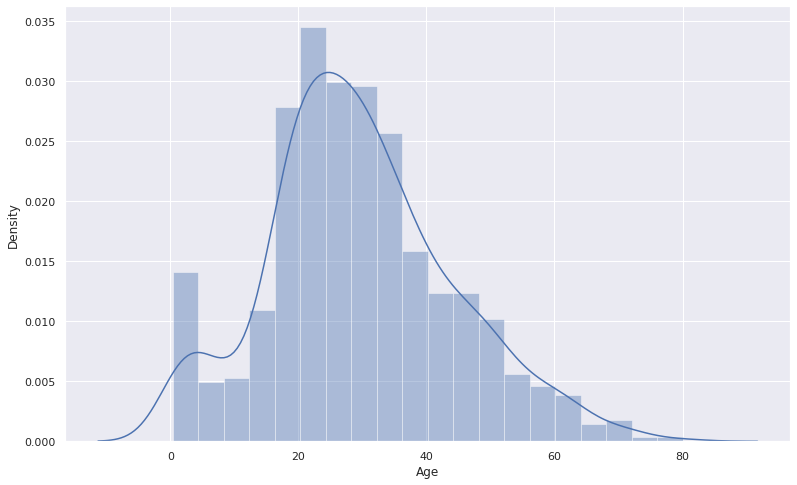

In [23]:
sns.distplot(df['Age'])

### Looks like a kinda normal-enough curve. I just wanted to make sure that before we impute we arent pumping our data full of a bunch of highly skewed values. Let us check with math!

In [24]:
# check for normal distribution
stat, p = shapiro(df['Age'].dropna())
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.981, p=0.000

Probably not Gaussian =/


### Noted. Im going to impute anyway for now, maybe this is something I can fiddle with in the future to see if it changes my accuracy.

In [25]:
#FIND MEAN AGE

df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [26]:
# now impute main data set with this mean age
df['Age'].fillna((df['Age'].mean()), inplace=True)

In [27]:
df['Age'].value_counts() # lookin good

29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
30.000000     25
19.000000     25
21.000000     24
25.000000     23
36.000000     22
29.000000     20
35.000000     18
32.000000     18
26.000000     18
27.000000     18
31.000000     17
16.000000     17
34.000000     15
20.000000     15
23.000000     15
33.000000     15
39.000000     14
40.000000     13
17.000000     13
42.000000     13
45.000000     12
38.000000     11
4.000000      10
2.000000      10
50.000000     10
44.000000      9
47.000000      9
48.000000      9
54.000000      8
9.000000       8
1.000000       7
51.000000      7
37.000000      6
52.000000      6
41.000000      6
3.000000       6
14.000000      6
49.000000      6
58.000000      5
15.000000      5
43.000000      5
62.000000      4
56.000000      4
8.000000       4
60.000000      4
11.000000      4
5.000000       4
6.000000       3
7.000000       3
65.000000      3
61.000000      3
46.000000      3
10.000000      2
64.000000     

In [28]:
#Check for remaining NULLs

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

### 2 nulls remaininng in Embarked. Im just gonna drop those two.

In [29]:
#drop nulls

df = df.dropna()

In [30]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

## Looking good, lets grow a random forest!

# 3. BUILD A MODEL

### First I want to split my (already split) data set so I can test without submitting the project. Then Ill make a new model that includes all the data, which should make it even better, and submit that.

In [31]:
# Splitting the data and creating a model


X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)

forest = RandomForestClassifier(n_estimators=100, random_state=100)

In [32]:
# Fit the model and make predictions! 
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)

In [33]:
# check model accuracy
print("Accuracy:",metrics.accuracy_score(y_test, predictions))


Accuracy: 0.8352059925093633


## better than I had hoped!

In [34]:
df_test.loc[df_test['Sex'] == 'male', 'Sex'] = 0
df_test.loc[df_test['Sex'] == 'female', 'Sex'] = 1
df_test.loc[df_test['Embarked'] == 'S', 'Embarked'] = 1
df_test.loc[df_test['Embarked'] == 'C', 'Embarked'] = 2
df_test.loc[df_test['Embarked'] == 'Q', 'Embarked'] = 3
del df_test['Name']
del df_test['Ticket']
df_test['Age'].fillna((df_test['Age'].mean()), inplace=True)

In [35]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [36]:
del df_test['Cabin']


In [37]:
df_test['Fare'].fillna((df_test['Fare'].mean()), inplace=True)

In [38]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [39]:
y = df["Survived"]

features = ["Pclass", "Sex", 'Age', "SibSp", "Parch", "Fare", "Embarked"]
X = pd.get_dummies(df[features])
X_test = pd.get_dummies(df_test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [40]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,1
1,2,1,1,1,38.0,1,0,71.2833,2
2,3,1,3,1,26.0,0,0,7.9250,1
3,4,1,1,1,35.0,1,0,53.1000,1
4,5,0,3,0,35.0,0,0,8.0500,1
